In [70]:
import numpy as np
import xarray as xr
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import sys
from matplotlib.gridspec import GridSpec


In [71]:
def icepack_init_wave(wave_spec_dir, wave_spec_file, nfreq):
    #Hardcoded for 20 frequencies
    if wave_spec_file == 'efreq_test_1freq.txt':
        wavefreq=np.arange(0.05,1.05,0.05)
    else:
        wavefreq=np.array([0.04118, 0.045298, 0.0498278, 0.05481058, 0.06029164, 0.06632081, 0.07295289, 0.08024818, 0.08827299, 0.09710029, 0.10681032, 0.11749136, 0.1292405, 0.14216454, 0.15638101, 0.17201911, 0.18922101, 0.20814312, 0.22895744, 0.25185317])
    
    wave_spectrum=np.genfromtxt(str(wave_spec_dir)+str(wave_spec_file), delimiter='\n')
    dwavefreq=wavefreq*(np.sqrt(1.1)-np.sqrt(1/1.1))

    return wave_spectrum, wavefreq, dwavefreq

def read_iceTankData(floe_size_dir, floe_size_file, floe_rad_l, floe_binwidth, nfsd):
    
    lengthsRaw1=np.loadtxt(str(floe_size_dir)+str(floe_size_file))
    floe_size_file2='floesize_20230808_1Hz_1.5cm.txt'
    lengthsRaw2=np.loadtxt(str(floe_size_dir)+str(floe_size_file2))
    
    lengthsRaw=np.concatenate((lengthsRaw1, lengthsRaw2), axis=0)
    
    nfloes=lengthsRaw.shape[0]

    fraclengths=np.array([])
    for n in range(nfloes):
        fraclengths=np.append(fraclengths,np.nanmean(lengthsRaw[n,:])/100)
    
    frachistogram=np.zeros(nfsd)
    if all(lengths <= floe_rad_l[0] for lengths in fraclengths):
        frachistogram=np.zeros(nfsd)
    for j in range(nfloes):
                if (fraclengths[j] > floe_rad_l[0]):
                    for k in range(nfsd-1):
                        if (fraclengths[j] >= floe_rad_l[k]) and (fraclengths[j] < floe_rad_l[k+1]):
                            frachistogram[k]=frachistogram[k]+1
                            print(fraclengths[j])
                if fraclengths[j]>floe_rad_l[nfsd-1]:
                    frachistogram[nfsd-1]=frachistogram[nfsd-1]+1
                    
    frac_local=frachistogram/nfloes
    print(nfloes)
    print(frac_local)
    return frac_local
    
def get_fraclength(X,eta,fraclengths,hbar, nx, dx):
    threshold=10
    spcing=round(threshold/dx)
    is_max=np.full(nx, False, dtype=bool)
    is_min=np.full(nx, False, dtype=bool)
    is_extremum=np.full(nx, False, dtype=bool)
    is_triplet=np.full(nx, False, dtype=bool)
    strain=np.zeros(nx)
    fracdistances=np.zeros(nx)
    fraclengths=np.zeros(nx)
    straincrit=3e-5
    j_neg=0
    j_pos=0
    
    # Look for first point
    if(eta[0] > eta[1]):
        is_max[0]=True
        is_extremum[0]=True
    elif(eta[0] < eta[1]):
        is_min[0]=True
        is_extremum[0]=True

    # Check all point
    for j in range(1, nx-1):
        # Min
        if(eta[j-1] > eta[j] < eta[j + 1]):
            is_min[j]=True
            is_extremum[j]=True
        # Max
        elif(eta[j-1] < eta[j] > eta[j + 1]):
            is_max[j]=True
            is_extremum[j]=True
    
    if(eta[-1] > eta[-2]):
        is_max[nx-1]=True
        is_extremum[nx-1]=True
    elif(eta[-1] < eta[-2]):
        is_min[nx-1]=True
        is_extremum[nx-1]=True
        
    nabove=0
    # Are they triplets ? 
    for j in range(1, nx-1):
        # Find 3 consecutive min/max
        if (is_extremum[j]):
            if (j==1):
                if (is_extremum[0]):
                    j_neg=0
            else:
                for k in range(j-1, 0, -1):
                    if (is_extremum[k]):
                        j_neg=k
                        break
            for k in range(j+1, nx, 1):
                if (is_extremum[k]):
                    j_pos=k
                    break
                              
            if (is_max[j_neg]) and (is_min[j]) and (is_max[j_pos]):
                is_triplet[j]=True
            if (is_min[j_neg]) and (is_max[j]) and (is_min[j_pos]):
                is_triplet[j]=True
                
            # Compute strain 
            if (is_triplet[j]):
                delta_pos=X[j_pos]-X[j]
                delta=X[j]-X[j_neg]
                denominator = delta*delta_pos*(delta+delta_pos)
                if (denominator > 0):
                    strain[j] = hbar*np.abs((eta[j_neg]*delta_pos-eta[j]*(delta_pos+delta)+eta[j_pos]*delta)/denominator)
                    if strain[j]>straincrit:
                        nabove=nabove+1
                        # fracdistances[j]=X[j]
    if (nabove > 0):
        k=0
        for j in range(nx):
            if (strain[j] > straincrit):
                fracdistances[k]=X[j]
                k=k+1    
        for j in range(nabove-1):
            fraclengths[j]=fracdistances[j+1]-fracdistances[j]
    
    
    # Plotting for validation       
    k=0
    fig = plt.figure(figsize=[14, 8])
    gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.1, top=0.95) 

    # # Plot 
    axes = fig.add_subplot(gs[0, 0])
    axes.plot(X, eta, color = 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    axes.set_ylabel(r'y [m]', size=24)
    axes.set_xlabel(r'x [m]', size=24)
    axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    # plt.savefig('wave_frac1.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)


     
    for j in range(nx):
        if is_triplet[j]:
            axes.axvline(x = X[j], color = 'b', linewidth=0.75)
    # plt.savefig('wave_frac2.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
    
    for j in range(nx):
        if is_triplet[j]:
            if strain[j]>straincrit:
                x_values=[X[j], X[j]+fraclengths[k]]
                y_values=[0,0]
                plt.plot(x_values, y_values, 'ro')
                k=k+1
                
    # plt.savefig('wave_frac3.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
    k=0
    for j in range(nx):
        if is_triplet[j]:
            if strain[j]>straincrit:
                x_values=[X[j], X[j]+fraclengths[k]]
                y_values=[0,0]
                plt.plot(x_values, y_values, 'ro', linestyle="--")
                k=k+1

    plt.savefig('wave_frac4_numericalTank.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

    
    return fraclengths[fraclengths!=0]


def strain_wave_frac(wave_spectrum, wavefreq, dwavefreq, run_to_convergence, hbar, nfreq, nfsd, floe_rad_l, floe_rad_c, floe_binwidth, max_no_iter, frac_iceTank):
    
    #Free parameters
    nx=1000
    Lambda=9.81/(2*np.pi*wavefreq**2)
    dx=0.005
    errortol=6.5e-4
    puny = sys.float_info.epsilon

    #Working array
    X=np.zeros(nx)
    fraclengths=np.zeros(nx)
    eta=np.zeros(nx)
    frac_local=np.zeros(nfsd)
    prev_frac_local=np.zeros(nfsd)
    frachistogram=np.zeros(nfsd)
    spec_coeff=np.sqrt(2*wave_spectrum*dwavefreq)
    if not (run_to_convergence):
        loop_max_iter=1
    elif (run_to_convergence):
        loop_max_iter=max_no_iter
    
    index=0
    for j in np.arange (0, nx*dx, dx):
        X[index]=j
        index=index+1

    iter=0
    fracerror=np.inf
    while(iter<loop_max_iter) and (fracerror > errortol):
    
        iter=iter+1
        if (run_to_convergence):
            rand_array=np.random.random(nfreq)
        elif not (run_to_convergence):
            rand_array=np.ones(nx)/2
            
        phi=2*np.pi*rand_array
        for j in range(nx):
            # test=np.array([0,0,0,0,0,0,-0.001,-0.001,-0.001,-0.001,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01])
            # spec_coeff=np.exp(test*j)*np.sqrt(2*wave_spectrum*dwavefreq)
            
            summand=spec_coeff*np.cos(2*np.pi*X[j]/Lambda+phi)
            # eta[j]=np.exp(-0.005*j)*np.sum(summand)
            eta[j]=np.sum(summand)
        if (np.sum(abs(eta)) > puny) and (hbar > puny):
            # fraclengths=get_fraclength(X,eta,fraclengths,hbar, nx, dx)/2 #Diameter to radius
            fraclengths=get_fraclength(X,eta,fraclengths,hbar, nx, dx) #Keep it to diameter (for ice tank exp.)
        if all(lengths <= floe_rad_l[0] for lengths in fraclengths):
            frac_local=np.zeros(nfsd)
        else:
            for j in range(np.shape(fraclengths)[0]):
                if (fraclengths[j] > floe_rad_l[0]):
                    for k in range(nfsd-1):
                        if (fraclengths[j] >= floe_rad_l[k]) and (fraclengths[j] < floe_rad_l[k+1]):
                            frachistogram[k]=frachistogram[k]+1
                            print(fraclengths[j])
                if fraclengths[j]>floe_rad_l[nfsd-1]:
                    frachistogram[nfsd-1]=frachistogram[nfsd-1]+1
            for k in range(nfsd):
                frac_local[k]=floe_rad_c[k]*frachistogram[k]
            if (np.sum(frac_local)!=0):
                frac_local=frac_local/np.sum(frac_local)
                
        if (run_to_convergence):
            fracerror=np.sum(abs(frac_local-prev_frac_local))/nfsd
            prev_frac_local=frac_local.copy()
            fig = plt.figure(figsize=[14, 8])
            gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
            fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

            # # Plot 
            axes = fig.add_subplot(gs[0, 0])
            axes.bar(floe_rad_c, frac_local, width = np.array(floe_binwidth), edgecolor='tab:blue',linestyle='--', zorder=8, linewidth=3, fill=False, label='Theory')
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            axes.set_ylabel(r'Frac. Hist. (H(r))', size=24)
            axes.set_xlabel(r'Floe size [m]', size=24)
            axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
            axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
            # axes.set_xscale('log')
            plt.savefig('frac_hist_numericalTank.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
            axes.bar(floe_rad_c, frac_iceTank, width = np.array(floe_binwidth), color='tab:red',edgecolor='black',zorder=8, label='Exp. 3+4')
            legend = plt.legend(fontsize=24)
            # axes.step(floe_rad_l,frac_iceTank, where='mid', color='red', linewidth=3, linestyle='solid', zorder=6)

            # axes.bar(floe_rad_l, frac_iceTank, width = np.array(floe_binwidth), edgecolor='black',zorder=8, alpha=0.25)
            
            plt.savefig('frac_hist_numericalTank_exp3-4.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

            # axes.set_xticks(floe_rad_l)
            # axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

            # if (fracerror <= errortol):
                # print("It converged after : ", iter, "iterations.")
                
    # if iter >= loop_max_iter:
    #     print("It did not converge")
    
    
    return frac_local


def get_dafsd_wave(nfsd, afsd_init, fracture_hist, frac, floe_rad_c, floe_binwidth):
    puny = sys.float_info.epsilon
    omega=np.zeros(nfsd)
    gain=np.zeros(nfsd)
    for k in range(nfsd):
        omega[k]=afsd_init[k]*np.sum(fracture_hist[:k])
    loss=omega.copy()
    
    
    for k in range(nfsd):
        gain[k]=np.sum(omega*frac[:,k])
        
    # fig = plt.figure(figsize=[14, 8])
    # gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    # fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

    # # # Plot 
    # axes = fig.add_subplot(gs[0, 0])
    # axes.bar(floe_rad_c, gain*4.5/1000, width = np.array(floe_binwidth), edgecolor='black',zorder=8)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # axes.set_ylabel(r'Gain [s$^{-1}$]', size=24)
    # axes.set_xlabel(r'Floe size [m]', size=24)
    # axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.set_xscale('log')
    # plt.savefig('gain.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
     
    
    # fig = plt.figure(figsize=[14, 8])
    # gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    # fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

    # # # Plot 
    # axes = fig.add_subplot(gs[0, 0])
    # axes.bar(floe_rad_c, loss*4.5/1000, width = np.array(floe_binwidth), edgecolor='black',zorder=8)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # axes.set_ylabel(r'Loss [s$^{-1}$]', size=24)
    # axes.set_xlabel(r'Floe size [m]', size=24)
    # axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.set_xscale('log')     
    # plt.savefig('loss.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

    d_afsd=gain.copy()-loss.copy()
    
    
    if np.sum(d_afsd)>puny:
        print("Area not conserved")
        
    d_afsd[d_afsd<puny]=0
    
    return d_afsd
    
def icepack_cleanup_fsd(ncat, nfsd, afsdn):
    for n in range(ncat):
        afsdn[:,n]=icepack_cleanup_fsdn(nfsd, afsdn[:,n])
        
    return afsdn    

def icepack_cleanup_fsdn(nfsd, afsd):
    puny = sys.float_info.epsilon
    for k in range(nfsd):
        if (afsd[k] < puny):
            afsd[k]=0
            
    tot=np.sum(afsd)
    if (tot>puny):
        for k in range(nfsd):
            afsd[k]=afsd[k]/tot
    else:
        afsd=np.zeros(nfsd)
    return afsd

def icepack_init_fsd(nfsd, floe_rad_c, floe_binwidth, afsd, wave_spec_file):
    if wave_spec_file == 'efreq_test_1freq.txt': #One big floe
        afsd=np.zeros(nfsd) 
        afsd[nfsd-1]=1
    else:
    # Perovitch 2014
        alpha=2.1
        tot_frac=0
        num_fsd=np.zeros(nfsd)
        floeshape=0.66
        floe_area_c=4*floeshape*floe_rad_c**2
        
        for k in range(nfsd):
            num_fsd[k]=(2*floe_rad_c[k])**(-alpha-1)
            afsd[k]=num_fsd[k]*floe_area_c[k]*floe_binwidth[k]
            
        afsd=afsd/np.sum(afsd)        
        
    return afsd
        
def icepack_step_wavefracture(trcrn, wave_spectrum, wavefreq, dwavefreq, aice, hbar, wave_solver, nfreq, nfsd, ncat, floe_rad_l, floe_rad_c, floe_binwidth, frac_iceTank):

    puny = sys.float_info.epsilon
    wave_sig_ht=4*np.sqrt(np.sum(wave_spectrum*dwavefreq))
    frac=np.zeros((nfsd,nfsd))
    max_no_iter=100
    

    if (aice > 0.01 and wave_sig_ht>puny):
        run_to_convergence=False
        if wave_solver=='std-conv':
            run_to_convergence=True
            
        fracture_hist=strain_wave_frac(wave_spectrum, wavefreq, dwavefreq, run_to_convergence,hbar,nfreq, nfsd, floe_rad_l, floe_rad_c, floe_binwidth, max_no_iter, frac_iceTank)
        if (max(fracture_hist) > puny):
            for n in range(ncat): #ncat
                afsd_init=trcrn[:,n]

        #         # if (aicen(n)> puny) and (np.sum(afsd_init) > puny) and (afsd_init[0] < 1):
                if (np.sum(afsd_init) > puny) and (afsd_init[0] < 1):
                    afsd_tmp=afsd_init.copy()
                    # print(afsd_tmp)
                    for k in range(1,nfsd):
                        frac[k,:k]=fracture_hist[:k]
                    for k in range(nfsd):
                        if (np.sum(frac[k,:])>0):
                            frac[k,:]=frac[k,:]/np.sum(frac[k,:])
                            
                    for subdt in range(1):
                        d_afsd_tmp=get_dafsd_wave(nfsd, afsd_tmp, fracture_hist, frac, floe_rad_c, floe_binwidth)
                        afsd_tmp=afsd_tmp+d_afsd_tmp
                        
                trcrn[:,n]=afsd_tmp
            trcrn=icepack_cleanup_fsd(ncat, nfsd, trcrn)
        
    # fig = plt.figure(figsize=[14, 8])
    # gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    # fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

    # # # Plot 
    # axes = fig.add_subplot(gs[0, 0])
    # axes.bar(floe_rad_c, frac[:, 0], width = np.array(floe_binwidth), edgecolor='black',zorder=8)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # axes.set_ylabel(r'Frac. probability $P(1, r\')$', size=24)
    # axes.set_xlabel(r'Floe size [m]', size=24)
    # axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.set_xscale('log')
    # plt.savefig('frac_prob.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

    
                         
    return trcrn
                                         # elapsed_t=0
                    # cons_error=0
                    # nsubt=0
                    
                    # while(elapsed_t < dt and nsubt < max_no_iter):
                    #     if (afsd_tmp[0] >= 1-puny):
                    #         break
                    #     nsubt=nsubt+1
                    

1.184
0.8066666666666668
0.8863333333333333
0.9530000000000001
1.1846666666666665
0.7326666666666667
1.1726666666666667
0.7223333333333334
0.3196666666666667
0.7626666666666666
1.2936666666666665
11
[0.09090909 0.18181818 0.36363636 0.27272727 0.09090909 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
0.7799999999999999
0.78
0.7850000000000001
0.7799999999999998
0.7800000000000002


/tmp/ipykernel_2122553/2028922767.py:169: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('wave_frac4_numericalTank.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
/tmp/ipykernel_2122553/2028922767.py:256: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('frac_hist_numericalTank.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
/tmp/ipykernel_2122553/2028922767.py:263: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('frac_hist_numericalTank_exp3-4.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
/tmp/ipykernel_2122553/202

0.78
0.7800000000000001
0.7799999999999998
0.7850000000000001
0.7799999999999998
0.7799999999999998


/tmp/ipykernel_2122553/2028922767.py:256: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('frac_hist_numericalTank.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)
/tmp/ipykernel_2122553/2028922767.py:263: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('frac_hist_numericalTank_exp3-4.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)


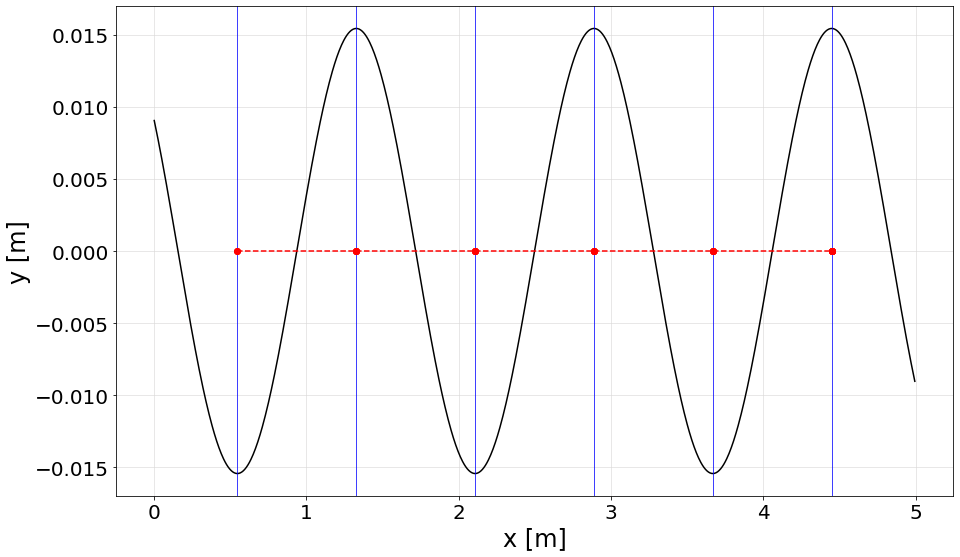

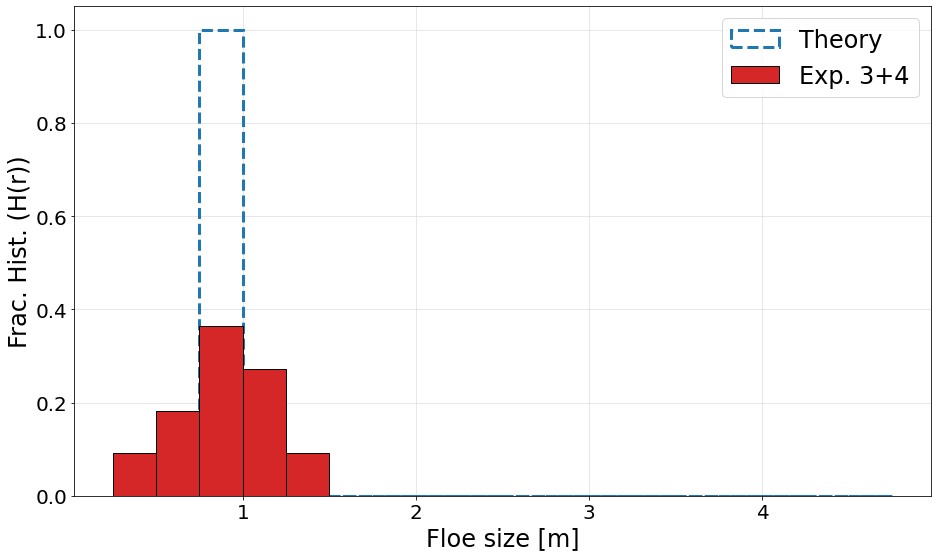

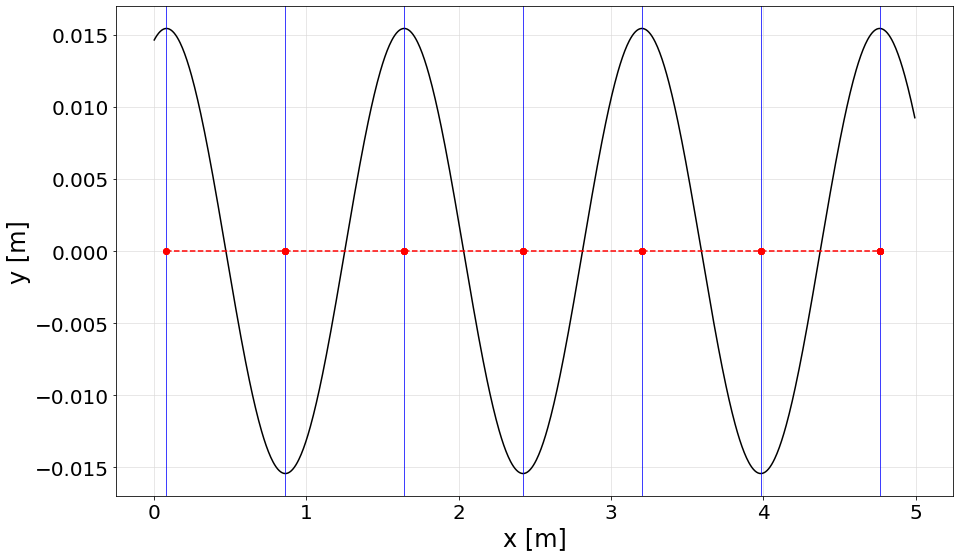

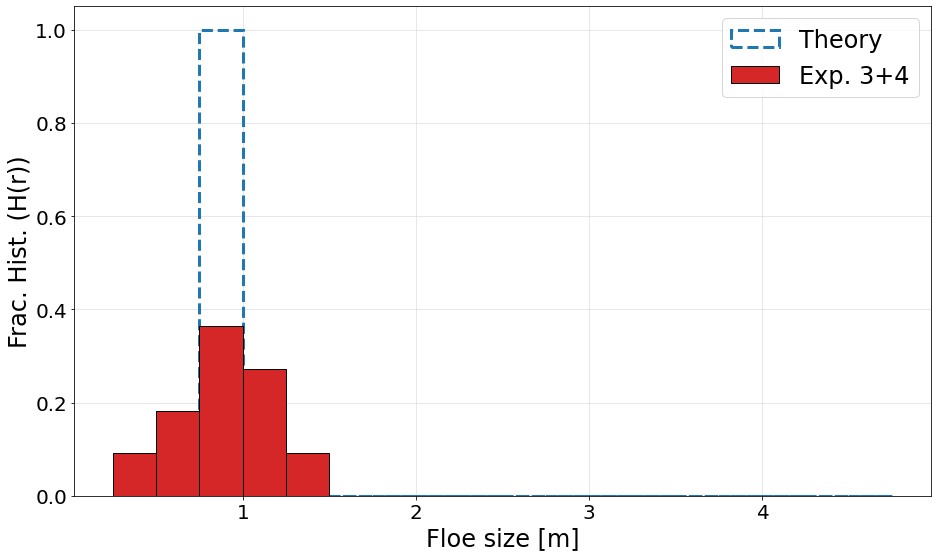

In [72]:
def main():

    wave_spec_dir='/aos/home/bward/icepack_wavefracspec/wavespec/'
    wave_spec_file='efreq_test_1freq.txt'
    
    floe_size_dir='/aos/home/bward/icepack_wavefracspec/icetank/'
    floe_size_file='floesize_20230809_1Hz_1.5cm.txt'
    # wave_spec_file='efreq_test_hfreq.txt'
    
    if wave_spec_file == 'efreq_test_1freq.txt':
        hbar=0.005
        lims = np.arange(0.25, 5, 0.25)
        nfreq=20
        wave_solver='std-conv'
        ncat=1
        nfsd=18
        aice=0.5
    else:
        hbar=1
        lims = np.array([6.65000000e-02,5.31030847e+00,1.42865861e+01,2.90576686e+01,
            5.24122136e+01,   8.78691405e+01,   1.39518470e+02,   2.11635752e+02,
            3.08037274e+02,   4.31203059e+02,   5.81277225e+02,   7.55141047e+02,
            9.45812834e+02])
        hbar=0.005
        nfreq=20
        wave_solver='std-conv'
        ncat=5
        nfsd=12
        aice=0.5
    
    floe_rad_l=lims[:-1]
    floe_rad_h=lims[1:]
    floe_rad_c=(floe_rad_l+floe_rad_h)/2
    floe_binwidth=floe_rad_h-floe_rad_l
    trcrn=np.zeros((nfsd,ncat))

    # Read FSD obs
    frac_IceTank=read_iceTankData(floe_size_dir, floe_size_file, floe_rad_l, floe_binwidth, nfsd)
    
    # # Initiate a dummy spectrum
    wave_spectrum, wavefreq, dwavefreq=icepack_init_wave(wave_spec_dir, wave_spec_file, nfreq)
    for n in range(ncat):
        trcrn[:,n]=icepack_init_fsd(nfsd, floe_rad_c, floe_binwidth, trcrn[:,n], wave_spec_file)
    
    # fig = plt.figure(figsize=[14, 8])
    # gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    # fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

    # # # Plot 
    # axes = fig.add_subplot(gs[0, 0])
    # axes.bar(floe_rad_c, trcrn[:,0], width = np.array(floe_binwidth), edgecolor='black',zorder=8)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # axes.set_ylabel(r'Areal FSD (F(r))', size=24)
    # axes.set_xlabel(r'Floe size [m]', size=24)
    # axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    # # axes.set_xscale('log')
    # # plt.savefig('fsd_init.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)    
    
    #Compute fracture
    for ts in range(1):
        trcrn=icepack_step_wavefracture(trcrn, wave_spectrum, wavefreq, dwavefreq, aice, hbar, wave_solver, nfreq, nfsd, ncat, floe_rad_l, floe_rad_c, floe_binwidth, frac_IceTank)

    # fig = plt.figure(figsize=[14, 8])
    # gs = GridSpec(1,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
    # fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) 

    # # # Plot 
    # axes = fig.add_subplot(gs[0, 0])
    # axes.bar(floe_rad_c, trcrn[:,0], width = np.array(floe_binwidth), edgecolor='black',zorder=8)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # axes.set_ylabel(r'Areal FSD (F(r))', size=24)
    # axes.set_xlabel(r'Floe size [m]', size=24)
    # axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    # axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    # # axes.set_xscale('log')
    # # plt.savefig('fsd_final.png',dpi='figure',format='png',metadata=None, bbbox_inches=None) 
     
if __name__ == '__main__':
    main()